# Assignment 4 - Automatically Formulating Trading Rules

## Lewis Johnston - 201979646
## John Reid - 201992904

### Statement of Contributions

Each individual contributed 50% towards the completion of this report.

### Introduction

Algorithmic trading is concerned with the implementation of computer programmes to execute financial trades, based on a pre determinded set of rules and instructions. The defined sets of instructions are based on timing, price, quantity, or any mathematical model (SETH, 2020). This area of trading was developed to utilise the speed and data processing advantages that computers have over humans.

The methods used within this report include Neural Networks (NN) and Genetic Algorithms (GA). The role of the NN is to make predictions based off the data it is provided with, and the GA then determines wether to buy or sell, based on the pre determined trading rules. This data used will be Amazon stock from the beginning of 2019 to the beginning of 2020. Using this data the NN will make predictions for the open and close price of future Amazon stock. With these predictions, the relative strength index (RSI) and Moving Average Convergence Divergence (MACD) will be calculated for the open price. These are two very popular technical indicators used in financial analysis and as such will serve as a good basis for detereming trading rules for our GA. The GA optimises our chosen parameters by examning our trading rules, which are influenced by the RSI and MACD. Using a GA, our model will then trade stocks at the close of trade using the recorded close price for chosen asset. The results of our model are then compared against a random solution. The random solution simply randomly selects when to buy or sell. 

With the growing popularity of Artificial Intelligence (AI) and benefits of Deep Learning within the past decade, neural networks and other AI techniques have become increasingly popular within many industries and professional services, especially finance. The choice to utilise a NN came from reading papers about their use for financial forecasting and trading. A paper by (Leung, Chen and Daouk, 2001) highlight the effectivness of using a NN for algorithmic trading and state that when using a NN "trading strategies guided by forecasts of the direction of price movement may be more effective and lead to higher profits". Using a GA alongside a NN has also been proven to have benifits when attempting to predict a stocks closing price. The proposed model proved its ability to provide closing price predictions with superior accuracy (Nayak and Misra, 2018). These two papers, alongside the knowledge gained from other moduels concerning NN's were the basis of using a mixture of these two methods. 

In [ ]:
#Installing relevant packaages

install.packages('GA')
install.packages('quantmod')
install.packages('neuralnet')
install.packages('Metrics')
install.packages('foreach')
install.packages('zoo')

In [1]:
#Loading relevant packages

library(GA)
library(quantmod)
library(neuralnet)
library(Metrics)

Warning message:
"package 'GA' was built under R version 3.6.2"Loading required package: foreach
Warning message:
"package 'foreach' was built under R version 3.6.3"Loading required package: iterators
Warning message:
"package 'iterators' was built under R version 3.6.2"Package 'GA' version 3.2
Type 'citation("GA")' for citing this R package in publications.

Attaching package: 'GA'

The following object is masked from 'package:utils':

    de

Warning message:
"package 'quantmod' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.2"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: TTR
Warning message:
"package 'TTR' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.f

In [2]:
#Obtaining our historical data from Yahoo Finance and setting the dates we want to evaluate our stock over.

stocks <- c('AMZN')

AMZN_Stocks <-getSymbols(stocks,
                   src="yahoo",
                   from="2019-01-01",
                   to="2020-03-01",
                   env=NULL)

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.



The choise of stock is Amazon. The reasoning behind this stock is simply because it is one of the largest companies in the world, and as such it has a relativly steady profit margin. This can help us evaluate our model as we can have a rough idea of what our predictions should look like and assets with more standard movement can benefit from improved returns. However, it should be noted that the stock market is notorisouly difficult to predict accurately as stock price movements are characterized by high volatility and nonlinearity. 

In [3]:
#This shows the different subsections of our stock data

AMZN_Stocks

           AMZN.Open AMZN.High AMZN.Low AMZN.Close AMZN.Volume AMZN.Adjusted
2019-01-02   1465.20   1553.36  1460.93    1539.13     7983100       1539.13
2019-01-03   1520.01   1538.00  1497.11    1500.28     6975600       1500.28
2019-01-04   1530.00   1594.00  1518.31    1575.39     9182600       1575.39
2019-01-07   1602.31   1634.56  1589.19    1629.51     7993200       1629.51
2019-01-08   1664.69   1676.61  1616.61    1656.58     8881400       1656.58
2019-01-09   1652.98   1667.80  1641.40    1659.42     6348800       1659.42
2019-01-10   1641.01   1663.25  1621.62    1656.22     6507700       1656.22
2019-01-11   1640.55   1660.29  1636.22    1640.56     4686200       1640.56
2019-01-14   1615.00   1648.20  1595.15    1617.21     6005900       1617.21
2019-01-15   1632.00   1675.16  1626.01    1674.56     5998500       1674.56
2019-01-16   1684.22   1705.00  1675.88    1683.78     6366900       1683.78
2019-01-17   1680.00   1700.17  1677.50    1693.22     4208900       1693.22

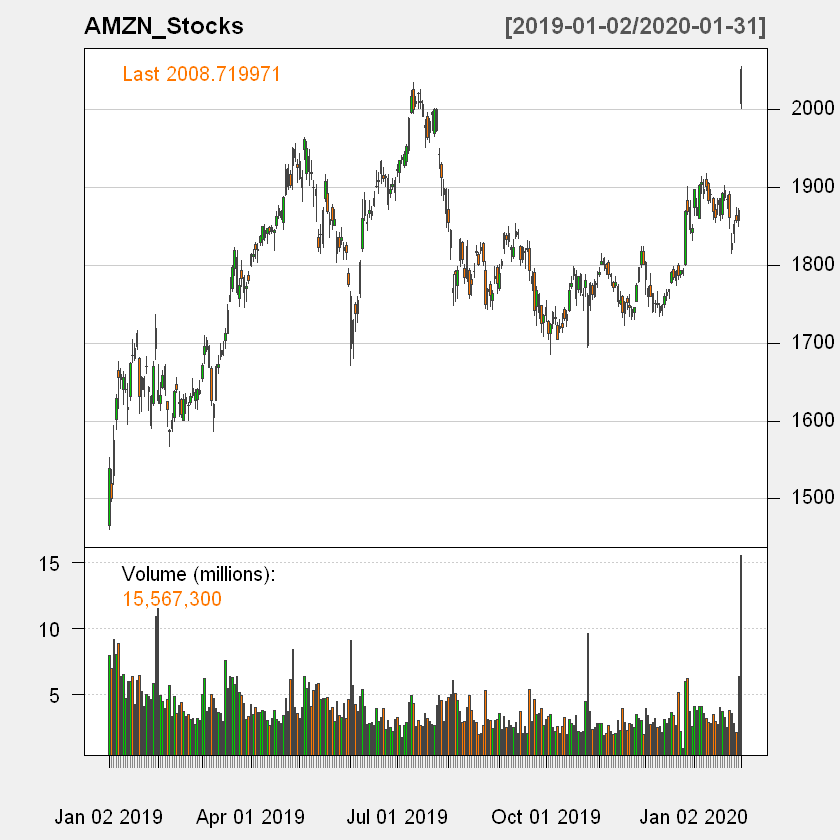

In [4]:
#Plotting our stock data

chartSeries(AMZN_Stocks,
            subset='2019-01::2020-01',
            theme=chartTheme('white'))

In [5]:
#Stating the simple moving average (SMA) we will use

sma <-SMA(Cl(AMZN_Stocks),n=20)

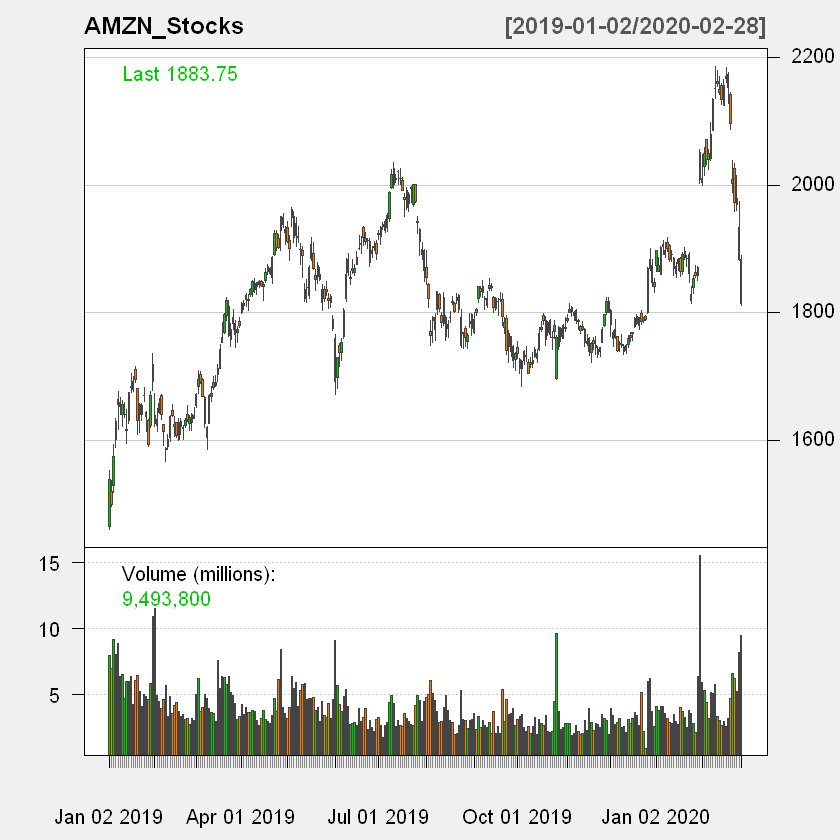

In [6]:
chartSeries(AMZN_Stocks,
            subset='2019-01::2020-01',
            theme=chartTheme('white'))

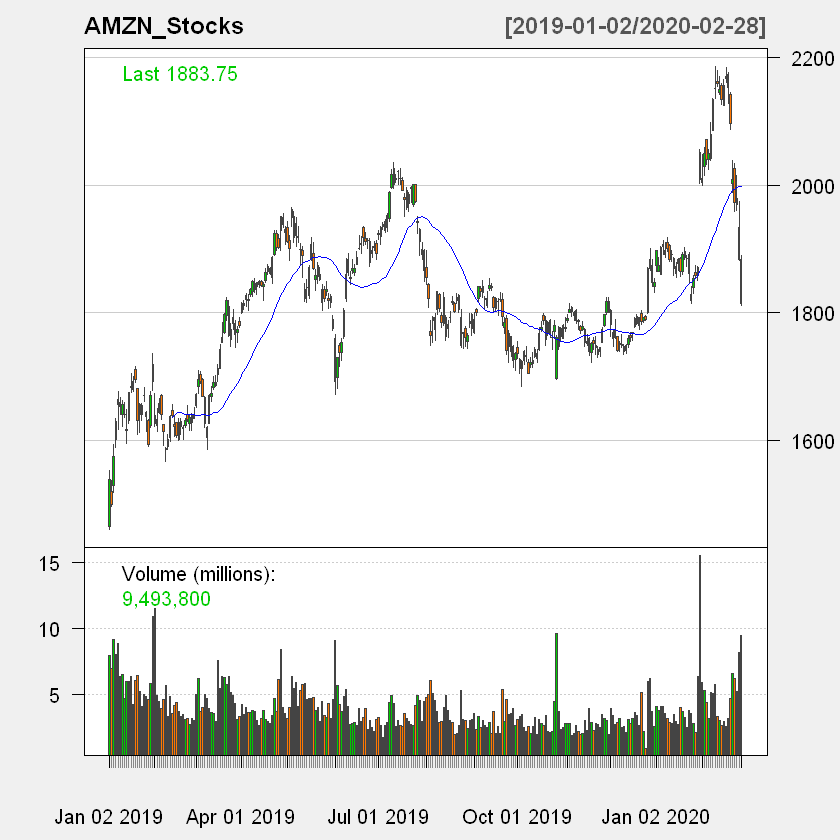

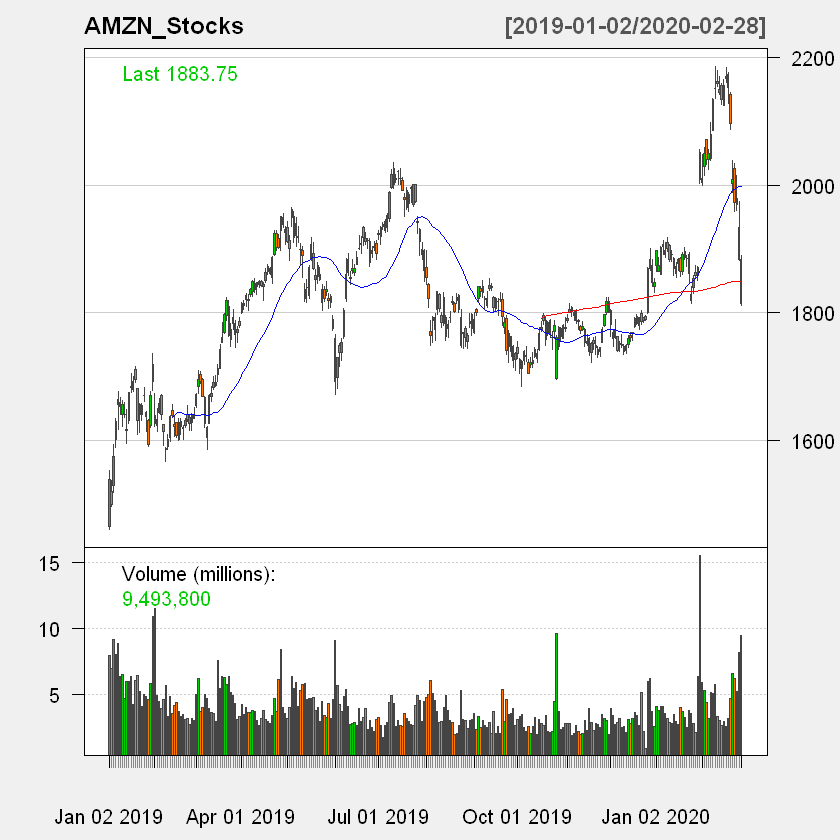

In [7]:
#Adding the SMA values of 30 days and 200 days

addSMA(n=30,on=1,col = "blue")
addSMA(n=200,on=1,col = "red")

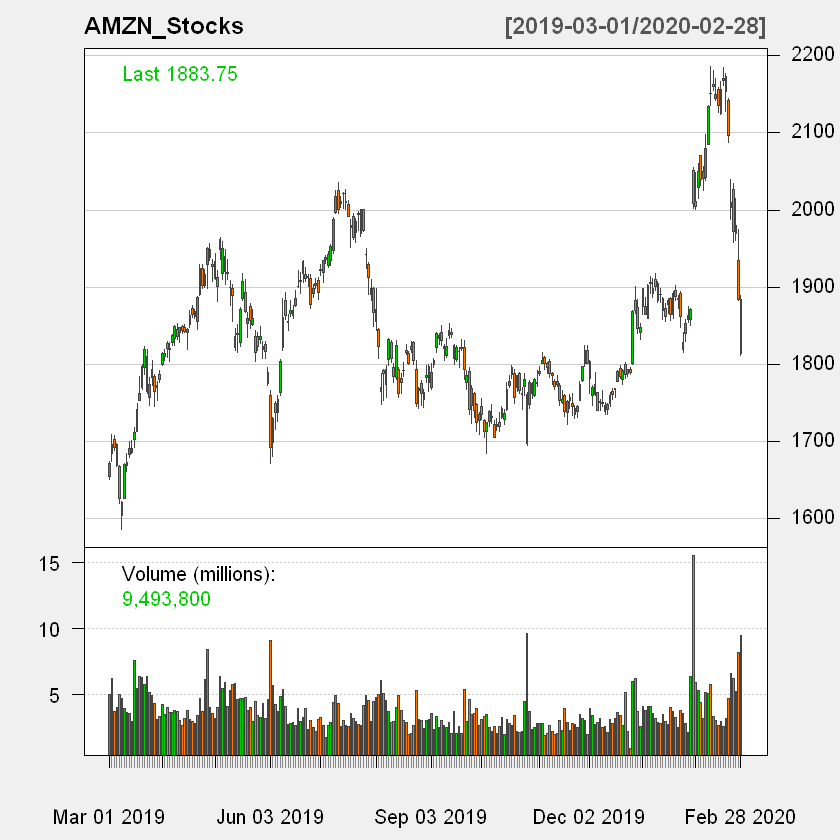

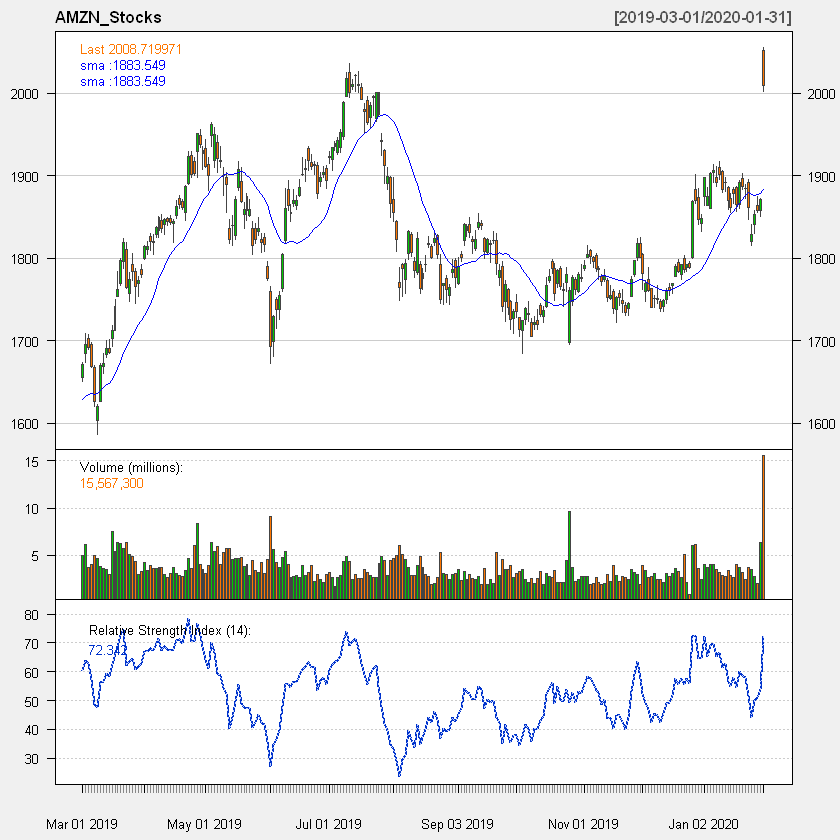

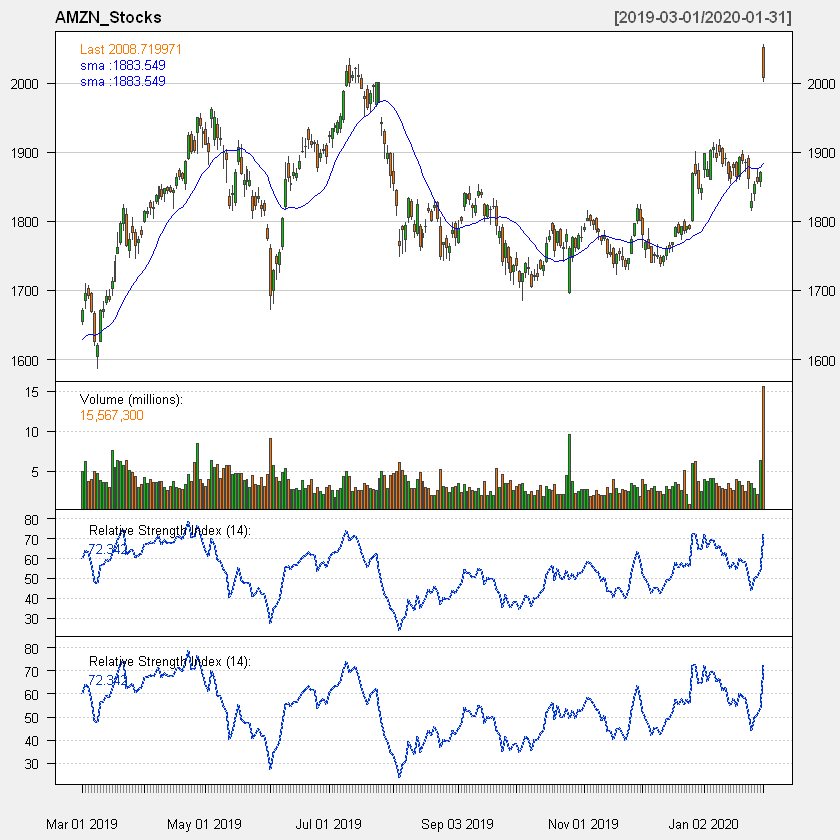

In [ ]:
#Creating a plot graphs function for use later on in the report.

Plot_Graphs <- function(train_data,train_results, test_data, test_results){
    
    # Plot train and test accuracy
  plot(train_data[,1], lwd=4, col=1, main="Training", ylim=c(-3,3),ylab = "Price",  panel.first = grid())
  lines(train_data[,2],lwd=3.5 ,col=2)
  lines(train_results[,1],lwd = 2.5, col=3)
  lines(train_results[,2],lwd=2, col=4)
  legend("topleft",  c("Close Price", "Open Price", "Predicted Close", "Predicted Open"), cex=1.0, fill=1:4)
 
  plot(test_data[,1], lwd=4, col=1, main="Test", ylim=c(-3,3), ylab="Price", panel.first = grid())
  lines(test_data[,2],lwd=3.5 ,col=2)
  lines(test_results[,1],lwd = 2.5, col=3)
  lines(test_results[,2],lwd=2, col=4)
  legend("topleft", c("Close Price", "Open Price", "Predicted Close", "Predicted Open"), cex=1.0, fill=1:4)
    
    
}   

### Creating the NN 

The role of the NN is to make predictions about the open and close price of Amazon stock. The stocks are collected over a period of 12 months. Firstly, we create a train/test split and convert the data frame to a time-series object. At this stage we also need to scale the data. Scaling is essential when working with NN's as they are unable to produce meaningful results with large numbers due to the activation functions inside the neural networks usually being in the range -1 to 1. The next step is to tell the neural network what we are trying to predict. We do this by devising a formula, with the first part of the formula denoting the values we are trying to predict, and the second part the values that can influence the desired output. We are trying to predict the open and close values based on all the other data in the time-series frame. Now we are ready to begin training the NN. We do this using the neuralnet package, passing through the training data and the parameters (no. of hidden layers, learning rate, epochs). Finally, we collect the results and re-scale them for use later on. After creating our NN and applying different lag values to our data, we then train our data.

In [88]:
#Creating our NN for predictions. 

getPredictions <- function(){

    train_data <- as.ts(Amzn_scale[1:test_split_index-1,])
    test_data <- as.ts(Amzn_scale[test_split_index:n_instances,])
    
    f <- as.formula("a + b ~ c + d + e + f + g + h + i + j")
    current_results <- neuralnet(f, data=train_data,  hidden=c(10,5,2), threshold = 0.1, stepmax=1000)
    train_predictions <- compute(current_results, train_data)
    train_results = train_predictions$net.result
    test_predictions <- compute(current_results, test_data)
    test_results = test_predictions$net.result
    #plots the graphs 
    Plot_Graphs(train_data, train_results, test_data, test_results)
    #gets the open and close data
    Amzn_close_price <- coredata(AMZN_Stocks)[,4]  
    open_train <- coredata(AMZN_Stocks)[,1][1:test_split_index-1]
    close_train <- coredata(AMZN_Stocks)[,4][1:test_split_index-1]
    open_test <- coredata(AMZN_Stocks)[,1][test_split_index:n_instances]
    close_test <- coredata(AMZN_Stocks)[,4][test_split_index:n_instances]
 

  #This rescales the new predictions   
  pred_open_train <- train_results[,2] * scale_parameters[[2]][2] + scale_parameters[[1]][2]
  pred_close_train <- train_results[,1] * scale_parameters[[2]][1] + scale_parameters[[1]][1]
  pred_open_test <- test_results[,2] * scale_parameters[[2]][2] + scale_parameters[[1]][2]
  pred_close_test <- test_results[,1] * scale_parameters[[2]][1] + scale_parameters[[1]][1]
 
  #Puts the prediction and actual prices into a list      
  f_return <- list(open_train, close_train,pred_open_train, pred_close_train,open_test, close_test,pred_open_test, pred_close_test)
 
  return(f_return)
}

Once the NN has been created, we collect the open and close prices and create 4 lags for each. Lagging the data allows the neural network to better understand the way the values of the data is moving.

In [89]:
# Keep runs consistent
set.seed(144)

#The amount to lag the next set of data by. 
lag_01 <- 1
lag_02 <- 2
lag_03 <- 3
lag_04 <- 4

In [90]:
AMZN_Stocks[,4]

           AMZN.Close
2019-01-02    1539.13
2019-01-03    1500.28
2019-01-04    1575.39
2019-01-07    1629.51
2019-01-08    1656.58
2019-01-09    1659.42
2019-01-10    1656.22
2019-01-11    1640.56
2019-01-14    1617.21
2019-01-15    1674.56
2019-01-16    1683.78
2019-01-17    1693.22
2019-01-18    1696.20
2019-01-22    1632.17
2019-01-23    1640.02
2019-01-24    1654.93
2019-01-25    1670.57
2019-01-28    1637.89
2019-01-29    1593.88
2019-01-30    1670.43
2019-01-31    1718.73
2019-02-01    1626.23
2019-02-04    1633.31
2019-02-05    1658.81
2019-02-06    1640.26
2019-02-07    1614.37
2019-02-08    1588.22
2019-02-11    1591.00
2019-02-12    1638.01
2019-02-13    1640.00
2019-02-14    1622.65
2019-02-15    1607.95
2019-02-19    1627.58
2019-02-20    1622.10
2019-02-21    1619.44
2019-02-22    1631.56
2019-02-25    1633.00
2019-02-26    1636.40
2019-02-27    1641.09
2019-02-28    1639.83
2019-03-01    1671.73
2019-03-04    1696.17
2019-03-05    1692.43
2019-03-06    1668.95
2019-03-07

In [91]:
Amzn_close_price <- coredata(AMZN_Stocks)[,4]

In [92]:
Amzn_close_price

[1] 1539.13 1500.28 1575.39 1629.51 1656.58 1659.42 1656.22 1640.56 1617.21
 [10] 1674.56 1683.78 1693.22 1696.20 1632.17 1640.02 1654.93 1670.57 1637.89
 [19] 1593.88 1670.43 1718.73 1626.23 1633.31 1658.81 1640.26 1614.37 1588.22
 [28] 1591.00 1638.01 1640.00 1622.65 1607.95 1627.58 1622.10 1619.44 1631.56
 [37] 1633.00 1636.40 1641.09 1639.83 1671.73 1696.17 1692.43 1668.95 1625.95
 [46] 1620.80 1670.62 1673.10 1690.81 1686.22 1712.36 1742.15 1761.85 1797.27
 [55] 1819.26 1764.77 1774.26 1783.76 1765.70 1773.42 1780.75 1814.19 1813.98
 [64] 1820.70 1818.86 1837.28 1849.86 1835.84 1847.33 1844.07 1843.06 1844.87
 [73] 1863.04 1864.82 1861.69 1887.31 1923.77 1901.75 1902.25 1950.63 1938.43
 [82] 1926.52 1911.52 1900.82 1962.46 1950.55 1921.00 1917.77 1899.87 1889.98
 [91] 1822.68 1840.12 1871.15 1907.57 1869.00 1858.97 1857.52 1859.68 1815.48
[100] 1823.28 1836.43 1819.19 1816.32 1775.07 1692.69 1729.56 1738.50 1754.36
[109] 1804.03 1860.63 1863.70 1855.32 1870.30 1869.67 1886.03 1901.37 1908.79
[118] 1918.19 1911.30 1913.90 1878.27 1897.83 1904.28 1893.63 1922.19 1934.31
[127] 1939.00 1942.91 1952.32 1988.30 2017.41 2001.07 2011.00 2020.99 2009.90
[136] 1992.03 1977.90 1964.52 1985.63 1994.49 2000.81 1973.82 1943.05 1912.45
[145] 1898.53 1866.78 1855.32 1823.24 1765.13 1787.83 1793.40 1832.89 1807.58
[154] 1784.92 1824.34 1762.96 1776.12 1792.57 1816.12 1801.38 1823.54 1804.66
[163] 1749.62 1768.87 1761.83 1764.25 1786.40 1776.29 1789.84 1800.62 1840.72
[172] 1833.51 1831.35 1820.55 1822.99 1843.55 1839.34 1807.84 1822.55 1817.46
[181] 1821.50 1794.16 1785.30 1741.61 1768.33 1739.84 1725.45 1735.91 1735.65
[190] 1713.23 1724.42 1739.65 1732.66 1705.51 1721.99 1720.26 1731.92 1736.43
[199] 1767.38 1777.43 1787.48 1757.51 1785.66 1765.73 1762.17 1780.78 1761.33
[208] 1777.08 1762.71 1779.99 1776.66 1791.44 1804.66 1801.71 1795.77 1788.20
[217] 1785.88 1771.65 1778.00 1753.11 1754.60 1739.49 1752.53 1752.79 1745.53
[226] 1734.71 1745.72 1773.84 1796.94 1818.51 1800.80 1781.60 1769.96 1760.69
[235] 1740.48 1751.60 1749.51 1739.21 1748.72 1760.33 1760.94 1769.21 1790.66
[244] 1784.03 1792.28 1786.50 1793.00 1789.21 1868.77 1869.80 1846.89 1847.84
[253] 1898.01 1874.97 1902.88 1906.86 1891.97 1901.05 1883.16 1891.30 1869.44
[262] 1862.02 1877.94 1864.72 1892.00 1887.46 1884.58 1861.64 1828.34 1853.25
[271] 1858.00 1870.68 2008.72 2004.20 2049.67 2039.87 2050.23 2079.28 2133.91
[280] 2150.80 2160.00 2149.87 2134.87 2155.67 2170.22 2153.10 2095.97 2009.29
[289] 1972.74 1979.59 1884.30 1883.75

In [93]:
#Adding our lag values to our data. 

Amzn_close_price_l1 <- Lag(Amzn_close_price, lag_01)
Amzn_close_price_l2 <- Lag(Amzn_close_price, lag_02)
Amzn_close_price_l3 <- Lag(Amzn_close_price, lag_03)
Amzn_close_price_l4 <- Lag(Amzn_close_price, lag_04)

In [94]:
#Showing the open price from our stock

Amzn_open_price <- coredata(AMZN_Stocks)[,1]
Amzn_open_price

[1] 1465.20 1520.01 1530.00 1602.31 1664.69 1652.98 1641.01 1640.55 1615.00
 [10] 1632.00 1684.22 1680.00 1712.00 1681.00 1656.00 1641.07 1670.50 1643.59
 [19] 1631.27 1623.00 1692.85 1638.88 1623.00 1643.34 1670.75 1625.00 1586.00
 [28] 1600.98 1604.00 1647.00 1624.50 1627.86 1601.00 1630.00 1619.85 1623.50
 [37] 1641.45 1625.98 1628.18 1635.25 1655.13 1685.00 1702.95 1695.97 1667.37
 [46] 1604.01 1626.12 1669.00 1683.00 1691.20 1703.00 1712.70 1753.51 1769.94
 [55] 1796.26 1810.17 1757.79 1793.00 1784.13 1770.00 1786.58 1800.11 1811.02
 [64] 1826.72 1820.65 1829.00 1833.23 1845.49 1841.00 1848.70 1848.40 1842.00
 [73] 1851.35 1872.99 1868.79 1855.40 1891.20 1925.00 1917.00 1929.00 1949.00
 [82] 1930.10 1933.09 1913.33 1949.00 1917.98 1939.99 1918.87 1900.00 1898.00
 [91] 1836.56 1839.50 1827.95 1885.94 1893.05 1852.69 1874.79 1851.78 1836.59
[100] 1835.89 1832.75 1823.12 1825.49 1790.01 1760.01 1699.24 1749.60 1737.71
[109] 1763.70 1822.00 1883.25 1853.98 1866.72 1864.00 1876.50 1901.35 1907.84
[118] 1933.33 1916.10 1912.66 1911.84 1892.48 1902.00 1909.10 1922.98 1919.38
[127] 1935.89 1928.60 1934.12 1947.80 1996.51 2025.62 2008.27 2021.40 2010.58
[136] 2007.05 1980.01 1991.21 1971.14 1995.99 1969.30 2001.00 1942.00 1930.00
[145] 1891.12 1898.11 1871.72 1845.07 1770.22 1792.23 1773.99 1806.00 1828.95
[154] 1795.99 1783.00 1793.01 1781.99 1792.89 1818.08 1814.50 1819.39 1828.00
[163] 1793.03 1766.91 1775.73 1755.00 1783.00 1797.49 1770.00 1805.00 1821.95
[172] 1838.22 1841.00 1822.75 1812.14 1837.63 1842.01 1824.02 1807.08 1817.04
[181] 1821.02 1821.71 1777.00 1790.61 1747.36 1762.79 1748.00 1726.99 1746.00
[190] 1727.74 1713.00 1726.02 1731.63 1722.49 1719.61 1725.24 1742.92 1728.91
[199] 1742.14 1773.33 1796.49 1787.80 1769.66 1788.15 1761.30 1771.09 1697.55
[208] 1748.06 1774.81 1760.24 1775.99 1788.01 1801.01 1809.16 1801.00 1803.76
[217] 1787.89 1778.00 1774.66 1773.39 1751.43 1760.05 1738.30 1756.99 1749.14
[226] 1743.00 1739.02 1753.25 1779.92 1801.00 1817.78 1804.40 1760.00 1774.01
[235] 1763.50 1751.20 1750.66 1747.40 1741.67 1750.00 1765.00 1767.00 1778.01
[244] 1795.02 1780.50 1799.62 1788.26 1793.81 1801.01 1882.92 1874.00 1842.00
[253] 1875.00 1864.50 1860.00 1904.50 1898.04 1909.89 1905.37 1891.31 1885.88
[262] 1872.25 1882.99 1885.89 1865.00 1896.09 1885.11 1891.37 1820.00 1840.50
[271] 1864.00 1858.00 2051.47 2010.60 2029.88 2071.02 2041.02 2041.99 2085.01
[280] 2150.90 2163.20 2144.99 2155.68 2125.02 2167.80 2173.07 2142.15 2003.18
[289] 2026.42 1970.28 1934.38 1814.63

In [95]:
#Adding our lag values to our open price stock data.

Amzn_open_price_l1 <- Lag(Amzn_open_price, lag_01)
Amzn_open_price_l2 <- Lag(Amzn_open_price, lag_02)
Amzn_open_price_l3 <- Lag(Amzn_open_price, lag_03)
Amzn_open_price_l4 <- Lag(Amzn_open_price, lag_04)

In [96]:
#Once the lags have been created, we combine them into a single data-frame.

Amzn_<- data.frame(Amzn_close_price, Amzn_open_price,Amzn_close_price_l1, Amzn_close_price_l2, Amzn_close_price_l3, Amzn_close_price_l4, Amzn_open_price_l1, Amzn_open_price_l2, Amzn_open_price_l3, Amzn_open_price_l4)
Amzn_ <- Amzn_[complete.cases(Amzn_),]
Amzn_scale <- scale(Amzn_, scale=TRUE, center = TRUE)
scale_parameters <- attributes(Amzn_scale)[3:4]

In [97]:
colnames(Amzn_scale) <- paste(c('a','b','c','d','e','f','g','h','i','j'))
rownames(Amzn_scale) <- NULL

In [100]:
n_instances <- length(Amzn_scale[,1])
test_split_index <- as.integer((n_instances / 100) * 80)

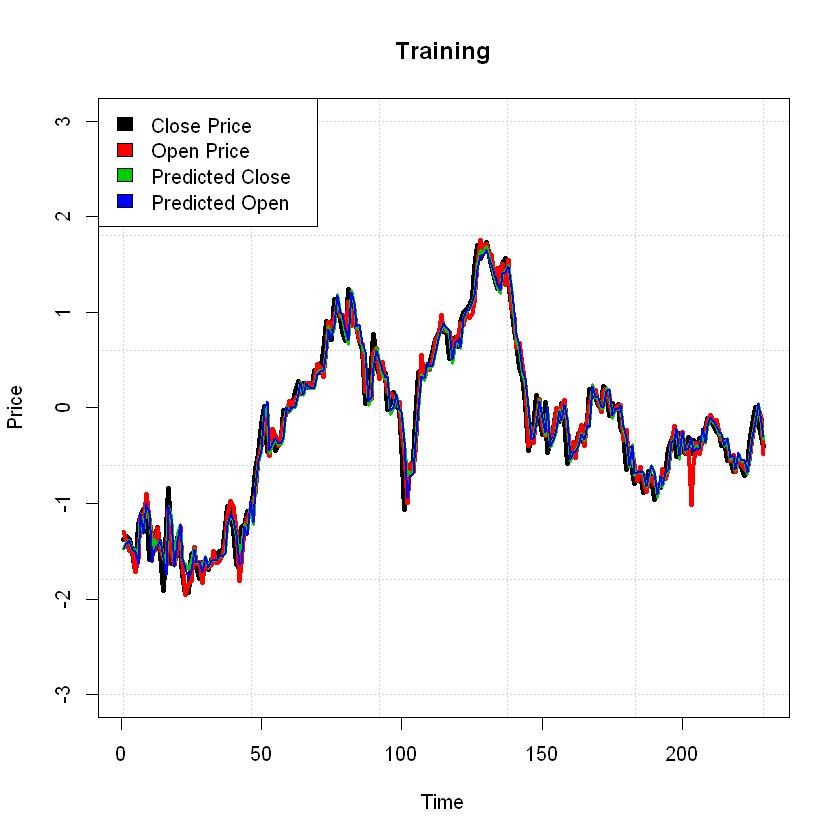

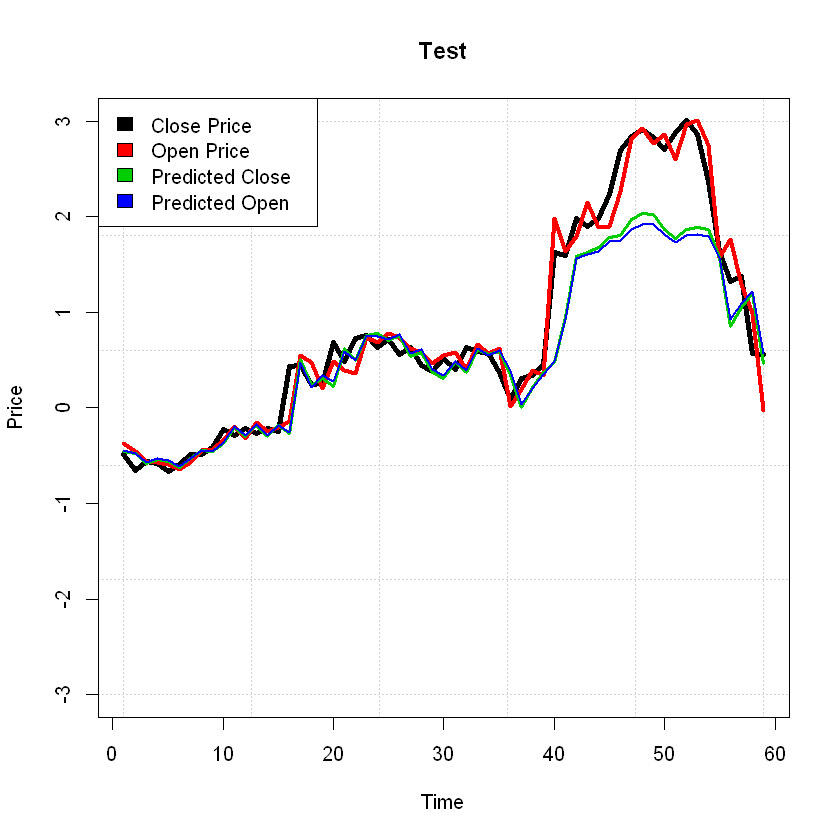

In [99]:
returns <- getPredictions()

In [34]:
returns[[6]]

[1] 1818.51 1800.80 1781.60 1769.96 1760.69 1740.48 1751.60 1749.51 1739.21
[10] 1748.72 1760.33 1760.94 1769.21 1790.66 1784.03 1792.28 1786.50 1793.00
[19] 1789.21 1868.77 1869.80 1846.89 1847.84 1898.01 1874.97 1902.88 1906.86
[28] 1891.97 1901.05 1883.16 1891.30 1869.44 1862.02 1877.94 1864.72 1892.00
[37] 1887.46 1884.58 1861.64 1828.34 1853.25 1858.00 1870.68 2008.72 2004.20
[46] 2049.67 2039.87 2050.23 2079.28 2133.91 2150.80 2160.00 2149.87 2134.87
[55] 2155.67 2170.22 2153.10 2095.97 2009.29

The accuracy of our NN over the training data seems to be fairly accurate, however, from inspection of the test results, we can see that the NN has not made predicitons with the same accuracy. This could be the result of over fitting, as well as there not being enough data provided. Over fitting can result in a loss of accuracy and large divergencies over the test data/period. Visually, this can be observed in latter third of the test results. To over come this a larger window/lag size could be utilised, as well as using data over a larger time period, thus providing more data. Undoubtably the more technical way to improve accuracy would be to utilise a NN architecture that has benifits when fed with time series data, such as a Recurrent Neural Network (RNN).

### GA Implementation

With our NN built and our predictions obtained the next step is to implement our trading rules for our GA. Our trading rules will be made up of observations of the RSI and MACD on our stocks open price. These are used to influence the decision of wether our GA buys or sells our stock. 

Warning message:
"timezone of object (UTC) is different than current timezone ()."

                rsi
2020-02-24 47.39876
2020-02-25 43.11341
2020-02-26 44.13285
2020-02-27 34.79221
2020-02-28 34.74650

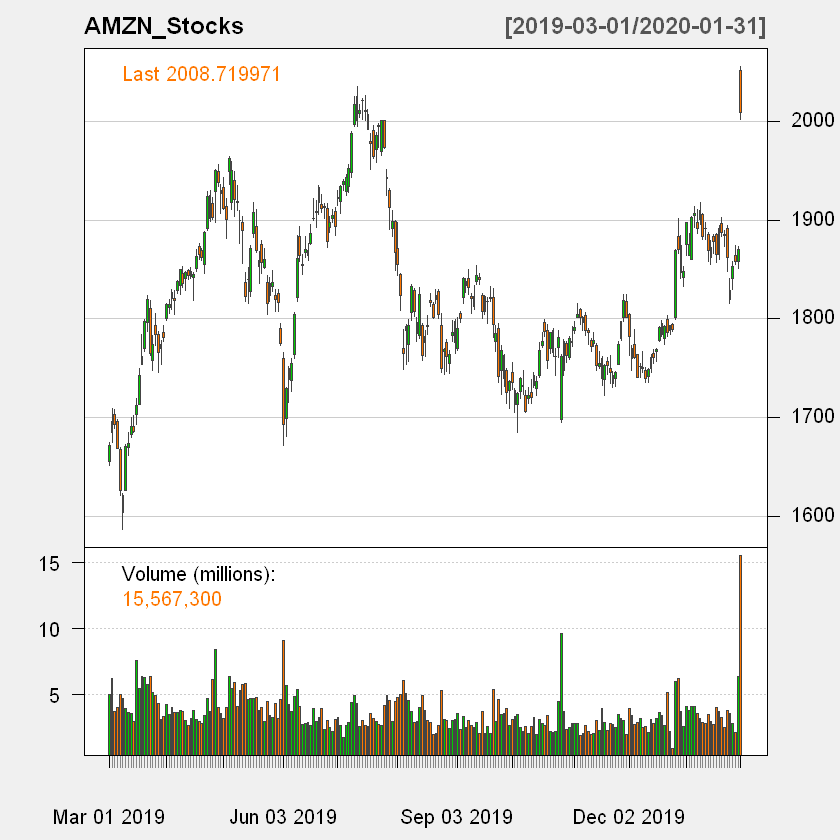

In [55]:
#Getting the RSI of our stock data

rsi = RSI(Cl(AMZN_Stocks), n=14)
tail(rsi,n=5)
chartSeries(AMZN_Stocks,
            subset='2019-03::2020-01',
            theme=chartTheme('white'))

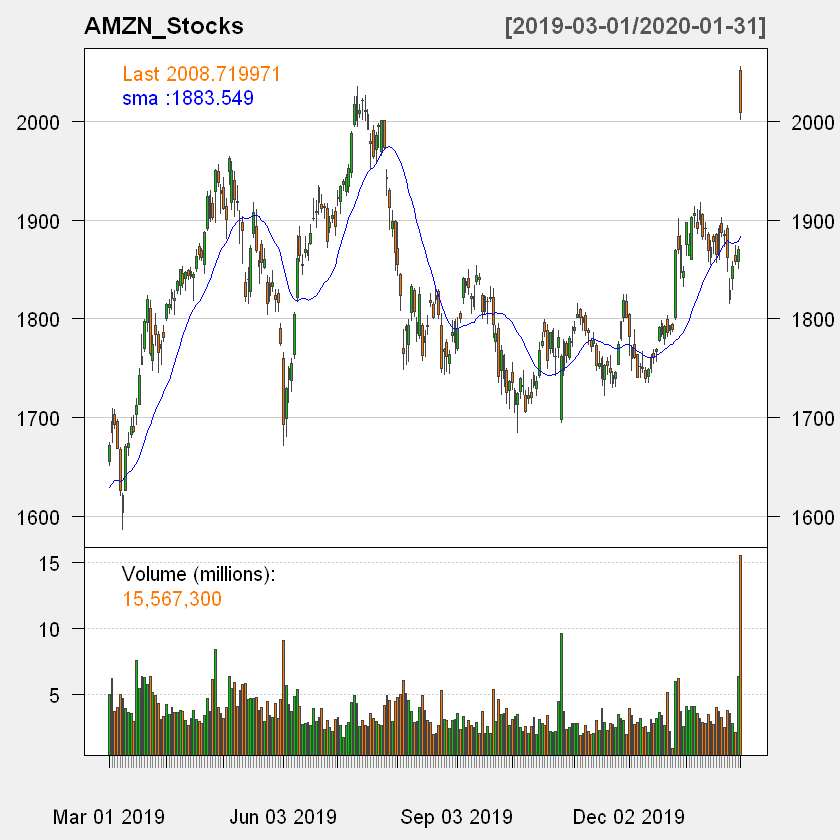

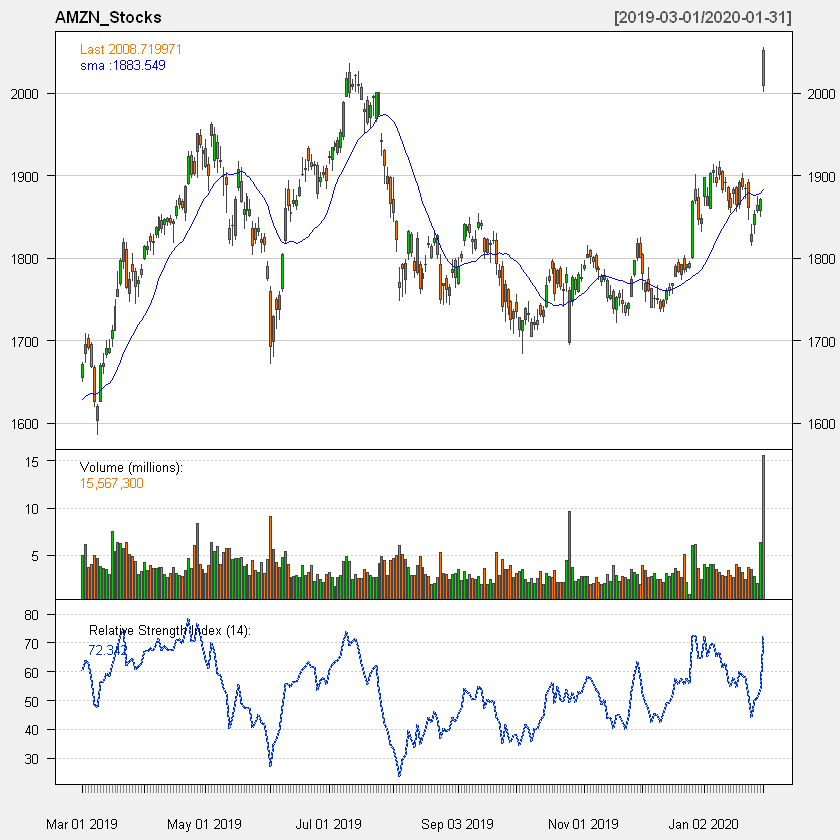

In [56]:
addTA(sma, on=1, col="blue")
addRSI(n=14,maType="EMA")

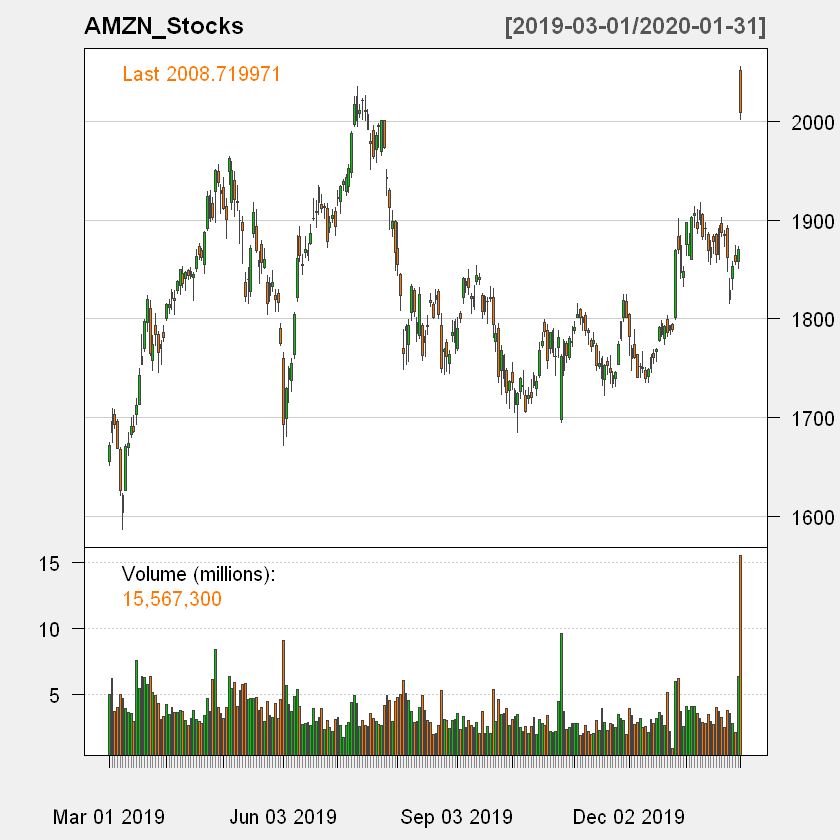

In [74]:
rsi = RSI(Cl(AMZN_Stocks), n=14)
chartSeries(AMZN_Stocks,
            subset='2019-03::2020-01',
            theme=chartTheme('white'))

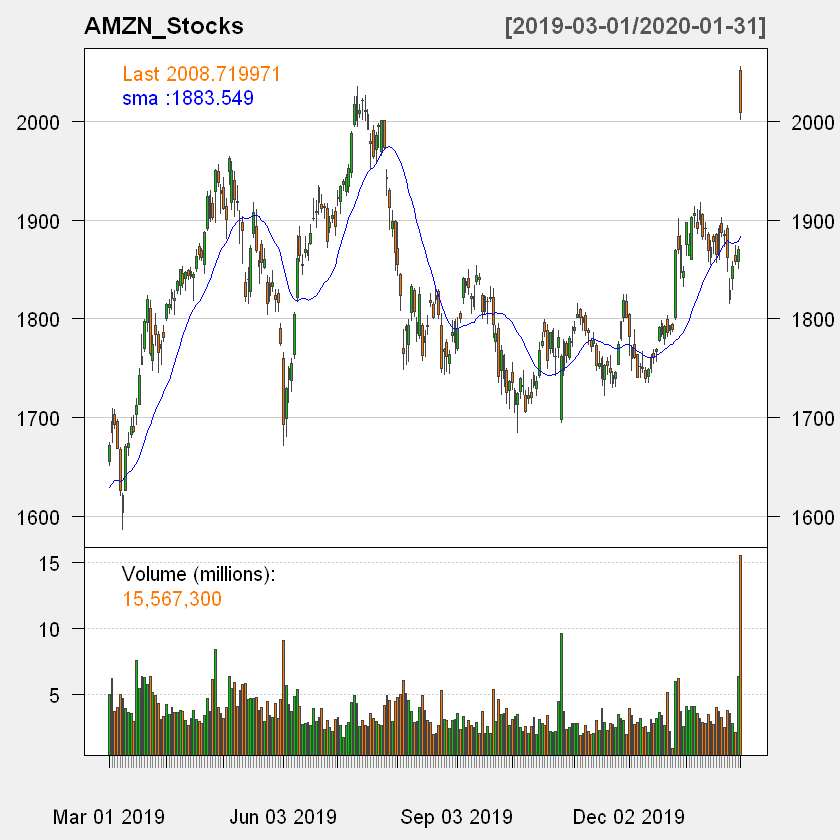

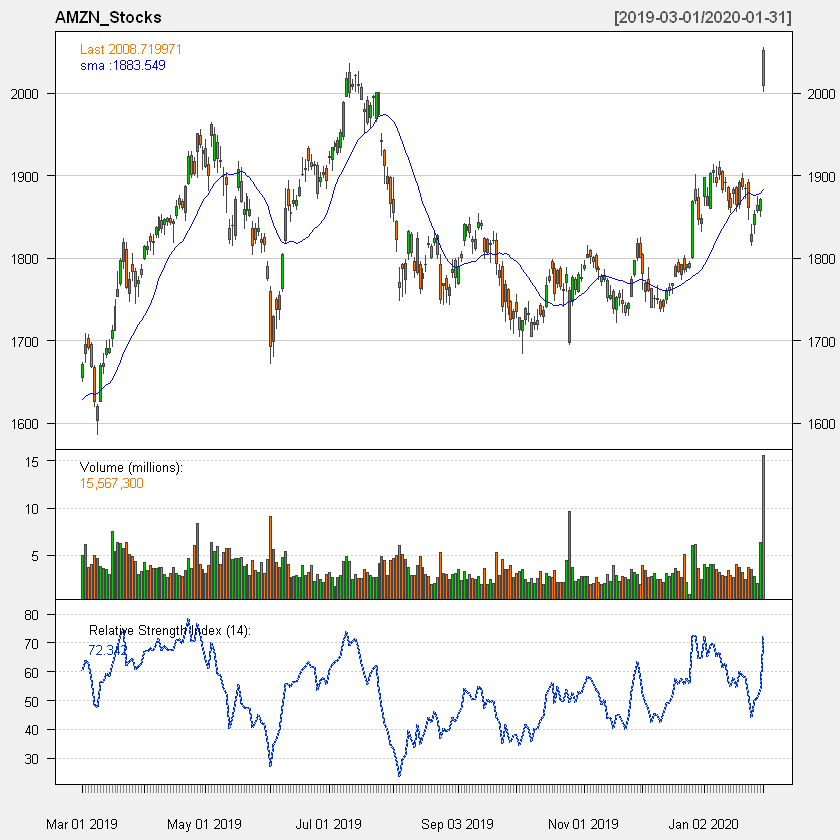

In [75]:
addTA(sma, on=1, col="blue")
addRSI(n=14,maType="EMA")

The GA is used to buy and sell stocks, for the MACD if the output is above 0.5 then buy, if its below -0.5 then sell. For RSI its simillar if the output is greater than 70% then buy and sell if 30%. the fitness function does this by comparing the macd open price to the preset buy threshold. The decision to buy or sell is then made. We collect the recorded close price of our asset for only the test period, as this is the simulated time at which trading takes place. We only use the test data as this can help simulate real world conditions. 

The MACD and RSI are calculated using the recorded open values for the training period, after which the neural network predictions are used. 

Our GA is influenced by 9 parameters: A temporary budget; amount of stocks held; buy price of previously obtained stock; the change in stock price (markup); and buy sell signals for RSI & MACD. The fitness function will analyse the the RSI and MACD vectors iteratively (simulating passing days) and make the decision, at the end of each day, to either buy, sell or hold the stock. The decision to buy/sell/hold is dependant on the RSI and MACD values and if they are in the ranges for buying/selling identified by the GA. The decision threshold stores the current decision value, which falls in the range -1 to 1. If the decision threshold is over 0.25, our GA will buy n amount of the asset, and if it is less than -0.25, it will sell n amount of the asset. For each metric, the decision threshold is multiplied by how far the current MACD/RSI values go over the threshold identified by the GA. Using the RSI as an example, a value greater than 70 indicates a buy signal; the system will then look at how far the current RSI value is over 70, normalize this to the range 0-1 with 0 being RSI == 70 and 1 being RSI == 100. This number is then used as the increment added to the decision threshold (which is also multiplied by the GA weights). Once calculated, a decision to buy/sell/hold assets is processed and performed for that day. 

In [58]:
close_pred <- returns[[6]]
macd_open <- MACD(append(returns[[1]], returns[[7]]), nFast = 3, nSlow = 7, nSig = 3)[test_split_index:n_instances]
rsi_open <- RSI(append(returns[[1]], returns[[7]]), n = 3)[test_split_index:n_instances]

In [69]:
fitness_function <- function(x)
{
    #Weights 
  weights <- (x[1:2])
  macd_open_weight <- weights[1]
  rsi_open_weight <- weights[2]
    
    
    
  #Initial setup 
  #These 9 parameters influence the decision of our model to buy/sell
  budget<-7000
  stocks_held <- 0
  buy_price <- 0
  markup <- x[3]
  buy <- x[4]
  sell <- x[5]
  rsibuy <- x[6] * 100
  rsisell <- x[7] * 100
  macdbuy <- x[8]
  macdsell <- x[9]
 
  #For loop simulates a trading day
  for(i in 1:length(macd_open))
  {
    decision <- 0
    if(macd_open[i] >= macdbuy)
    {
      multiply <- macd_open[i] / max(macd_open)
      decision <- decision - (1 * multiply) * macd_open_weight
    }
    else if(macd_open[i] <= -(macdsell))
    {
      multiply <- abs(macd_open[i]) / abs(min(macd_open))
      decision <- decision + (1 * multiply) * macd_open_weight
    }
   
  
    if(rsi_open[i] >= rsibuy)
    {
      multiply <- (rsi_open[i] - rsibuy) / (100 - rsibuy)
      decision <- decision - (1 * multiply) * rsi_open_weight
    }
    else if(rsi_open[i] <= rsisell)
    {
      multiply <- (rsisell-rsi_open[i]) / (rsisell)
      decision <- decision + (1 * multiply) * rsi_open_weight
    } 
    ##Decision to buy    
    if(decision >= buy)
    {
      asset_Price <- close_pred[i]
      if(budget > asset_Price){
        buy_Multiplier <- ((decision - 0.25) / 75) * 100
        maxAssets <- as.integer(budget / asset_Price)
        assetsToBuy <- as.integer(maxAssets * buy_Multiplier)
        stocks_held <- stocks_held + assetsToBuy
        budget <- budget - (asset_Price * assetsToBuy)
        buy_price <- asset_Price
      }
    }
    else if(decision <= -(sell))
    {
      if(stocks_held > 0)
      {
        asset_Price <- close_pred[i]
        if(asset_Price > buy_price  * (1 + markup)){
          sellMultiplier <- ((abs(decision) - 0.25) / 75) * 100
          sell_assets <- as.integer(stocks_held * sellMultiplier)
          budget <- budget + (asset_Price * sell_assets)
          stocks_held <- stocks_held - sell_assets
        }
      }
    }
   }
  dump <- stocks_held * close_pred[length(close_pred)]
  return(budget + dump)
    }

### Random Solution

To evaluate our NN/GA method we have compared it with a simple, random solution. The random solution predicts the price of our asset over the training period and randomly decides when to buy/sell/hold each day. For this solution, a random choice variable holds a value between -1 and 1, just like our GA above. If the random choice passes 0.25, we buy the maximum amount of stock we can, and vice versa if the choice falls below -0.25. Similar to our GA, any assets not sold at the end of the training period are sold and the final profit is calculated and returned.

In [ ]:
RandomResult <- function(x)
{
  recorded_close_test <- returns[[6]]
  predicted_close_test <- returns[[8]] 
  budget <- 7000
  stocks_held <- 0 
  for(i in 1:length(predicted_close_test)){
    currentAssetPrice <- recorded_close_test[i]
    randomChoice <- runif(1, -1, 1)
    if(randomChoice > 0.25)
    {
      assetsToBuy <- as.integer(budget / currentAssetPrice)
      stocks_held <- stocks_held + assetsToBuy
      budget <- budget - (currentAssetPrice * assetsToBuy)
    }
    else if (randomChoice < -0.25)
    {
      # sell
      budget <- budget + (currentAssetPrice * stocks_held)
      stocks_held <- 0
    }
  }
  dump <- stocks_held * recorded_close_test[length(recorded_close_test)]
  budget <- budget + dump
  profit <- ((budget - 7000) / 7000) * 100
  return(profit)
    }

In [71]:
#Getting accuracy of our GA

print("GA Running...")
GA<-ga(type='real-valued', fitness=fitness_function, lower=rep(0,9), upper=rep(1,9),
         popSize = 500, maxiter=1000,keepBest=TRUE)
budget <- GA@fitnessValue
profit <- ((budget - 7000) /7000) * 100
print("Done")
print(paste("GA return:", profit))

[1] "GA Running..."
[1] "Done"
[1] "GA return: 9.50828684285715"


In [51]:
randomResult <- 0

In [52]:
#Obtaining 1000 random results

for(i in 1:1000){
  randomResult <- randomResult + RandomResult()
}

In [53]:
randomResult <- randomResult / 1000
print(paste("Random Decision Average return:", randomResult))

[1] "Random Decision Average return: 4.30731723947143"


In [72]:
#Plotting the results (returns) of the two models used.

colors_vec = c("red","blue")
methods <- c("GA", "Random")
results <- c(gaResult, randomResult)

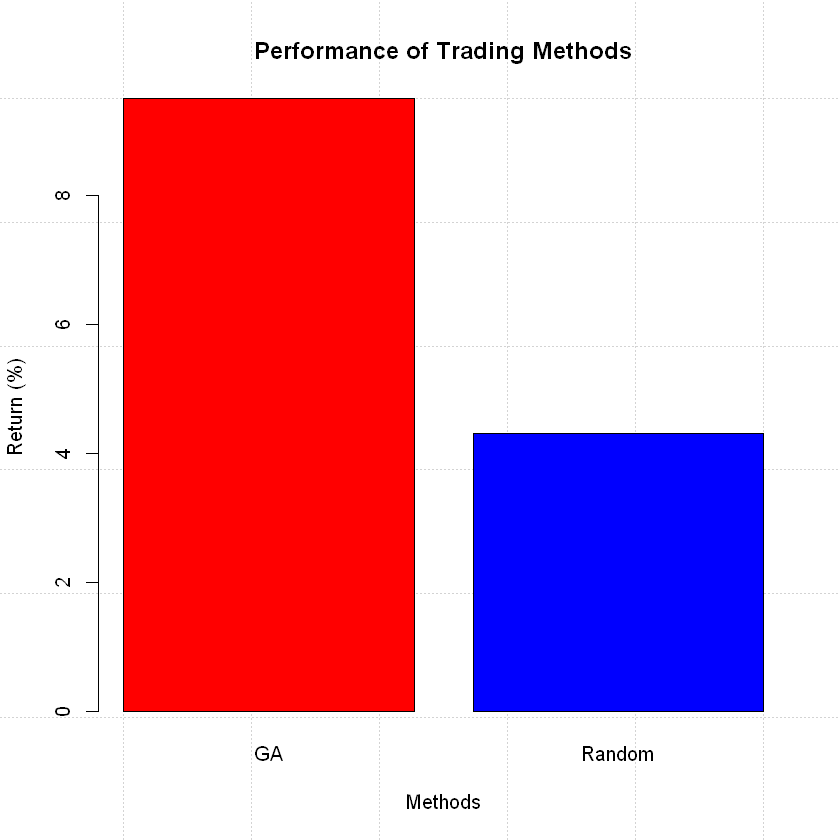

In [73]:
barplot(results,  main = "Performance of Trading Methods", col = colors_vec, names.arg = methods, xlab = "Methods", ylab = "Return (%)", , panel.first = grid())

### Results

The results of our mixed model system are fairly positive and significantly outperforms the random method. We can see that our mixed model is returning a profit of over 95%, while the random method returns are less than half of the mixed model, of just over a 40% return. The results could no doubt be increased if the mixed model had more data to work with and the NN part of the architecture was fine tuned to suit time series data. 

### References

-Leung, M., Chen, A. and Daouk, H., 2001. APPLICATION OF NEURAL NETWORKS TO AN EMERGING FINANCIAL MARKET: FORECASTING AND TRADING THE TAIWAN STOCK INDEX. [online] Web.ist.utl.pt. Available at: <http://web.ist.utl.pt/adriano.simoes/tese/referencias/Papers%20-%20Pedro/NN.pdf>.

-Nayak, S. and Misra, B., 2018. Estimating stock closing indices using a GA-weighted condensed polynomial neural network. Financial Innovation, [online] 4(1). Available at: <https://link.springer.com/article/10.1186/s40854-018-0104-2>.

-SETH, S., 2020. Basics Of Algorithmic Trading: Concepts And Examples. [online] Investopedia. Available at: <https://www.investopedia.com/articles/active-trading/101014/basics-algorithmic-trading-concepts-and-examples.asp>.